<h1><center><font size="6">Flutter Notebook</font></center></h1>

This notebook was completed after my capstone presentation.  This notebook is the code for developing the files to upload onto Flutter platform.

# Contents

- <a href='#1'>Importing Packages</a>  
- <a href='#2'>Generating Datasets</a>
- <a href='#3'>Creating Labels File</a>
- <a href='#4'>Creating Tensorflow Lite Model</a>
    - <a href='#41'>Generating the Datasets</a> 
    - <a href='#42'>Constructing and Compiling the Model</a> 
    - <a href='#43'>Defining Callbacks</a>
    - <a href='#44'>Training the Model</a>     
    - <a href='#45'>Evaluating the Model</a> 
    - <a href='#46'>Predicting on Holdout Set</a>
    - <a href='#47'>Confusion Matrix</a> 
    - <a href='#48'>Saving the Model</a> 
   

# Importing Packages

In [8]:
# importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.metrics import AUC, Precision, Recall

%reload_ext autoreload
%autoreload 2
from utils import *

# Generating Datasets

In [20]:
# create datasets for training, validation, and testing
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_fldr,
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (224, 224),
        batch_size = 1,
        class_mode = 'binary',
        shuffle = False,
        seed = 42)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

Found 6840 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.


# Creating labels file

In [3]:
# create labels.txt file that will hold all our labels for Flutter
print(train_generator.class_indices) 
labels = '\n'.join(sorted(train_generator.class_indices.keys())) 
with open('labels.txt', 'w') as f: 
    f.write(labels)


{'0_not_mel': 0, '1_mel': 1}


# Creating Tensorflow Lite Model

## Constructing the Model

In [10]:
# create base model for transfer learning
base_model = MobileNetV2(
    input_shape = (224, 224, 3),
    include_top = False, 
    weights = 'imagenet'
)

In [11]:
# freezes all neurons for base model
base_model.trainable = False 
# construct model
model = Sequential([ 
    base_model,
    Conv2D(32, 3, activation = 'relu'), 
    Dropout(0.2), 
    GlobalAveragePooling2D(), 
    Dense(1, activation = 'sigmoid')
])

## Compiling the Model

In [12]:
# compile model
model.compile(
    optimizer = Adam(lr = 0.001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy', Precision(), Recall(), AUC(), AUC(curve='PR')])

## Defining the Callbacks

In [13]:
# Define callbacks
lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 patience = 3,
                                 verbose = 1,
                                 factor = 0.5,
                                 min_lr = 0.00001)
filepath = "../logs/log_mobilenet/model.{epoch:02d}-{val_loss:.2f}.hdf5"
mcp_save = ModelCheckpoint(filepath, 
                           verbose = 1, 
                           monitor = 'val_loss', 
                           mode = 'min')
csv_logger = CSVLogger('../logs/log_mobilenet/log.csv')
log_dir = "../logs/log_mobilenet/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir = log_dir,
                             histogram_freq = 1,
                             update_freq = 'batch')

## Training the Model

In [14]:
# train model
history = model.fit_generator(generator = train_generator,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_data = valid_generator,
                             validation_steps = STEP_SIZE_VALID,
                             epochs = 20,
                             callbacks = [lr_reduction, mcp_save, tensorboard_cb, csv_logger])

Epoch 1/20
427/427 [==============================] - 1587s 4s/step - loss: 0.5235 - accuracy: 0.8869 - precision: 0.8485 - recall: 0.6114 - auc: 0.8917 - auc_1: 0.7546 - val_loss: 0.2168 - val_accuracy: 0.9335 - val_precision: 0.7889 - val_recall: 0.6961 - val_auc: 0.9333 - val_auc_1: 0.7753

Epoch 00001: saving model to ../logs/log_mobilenet/model.01-0.22.hdf5
Epoch 2/20
427/427 [==============================] - 1308s 3s/step - loss: 0.2316 - accuracy: 0.9504 - precision: 0.9395 - recall: 0.8442 - auc: 0.9749 - auc_1: 0.9405 - val_loss: 0.1856 - val_accuracy: 0.9495 - val_precision: 0.8795 - val_recall: 0.7228 - val_auc: 0.9508 - val_auc_1: 0.8569

Epoch 00002: saving model to ../logs/log_mobilenet/model.02-0.19.hdf5
Epoch 3/20
427/427 [==============================] - 1073s 3s/step - loss: 0.2022 - accuracy: 0.9619 - precision: 0.9566 - recall: 0.8794 - auc: 0.9789 - auc_1: 0.9560 - val_loss: 0.1851 - val_accuracy: 0.9335 - val_precision: 0.7321 - val_recall: 0.8039 - val_auc: 0.9

## Evaluating the Model

In [15]:
# create dataframe of training metrics
history = pd.read_csv("../logs/log_mobilenet/log.csv")
history

,epoch,accuracy,auc,auc_1,loss,lr,precision,recall,val_accuracy,val_auc,val_auc_1,val_loss,val_precision,val_recall
0,0,0.921014,0.946360,0.860156,0.329065,0.001000,0.918649,0.734356,0.933511,0.933258,0.775295,0.216841,0.788889,0.696078
1,1,0.952814,0.976807,0.952170,0.224536,0.001000,0.951624,0.845304,0.949468,0.950845,0.856861,0.185581,0.879518,0.722772
2,2,0.961460,0.979504,0.953359,0.195806,0.001000,0.952318,0.882750,0.933511,0.960490,0.818161,0.185147,0.732143,0.803922
3,3,0.960434,0.986020,0.970438,0.166530,0.001000,0.943864,0.887117,0.928191,0.955837,0.862048,0.193183,0.703390,0.813725
4,4,0.969959,0.986934,0.974654,0.146670,0.001000,0.957692,0.914881,0.952128,0.941636,0.873439,0.180245,0.923077,0.705882
5,5,0.966588,0.987823,0.976741,0.137123,0.001000,0.946463,0.911602,0.932181,0.940656,0.863416,0.188893,0.721739,0.813725
6,6,0.972157,0.990578,0.980575,0.119373,0.001000,0.958015,0.923926,0.952128,0.942187,0.878172,0.182778,0.912500,0.715686
7,7,0.975381,0.992776,0.985254,0.107477,0.001000,0.963245,0.932515,0.958777,0.930264,0.871182,0.201290,0.961039,0.725490
8,8,0.976993,0.993502,0.987185,0.096677,0.001000,0.962916,0.939877,0.948138,0.940762,0.878536,0.175666,0.838710,0.764706
9,9,0.978898,0.993998,0.988219,0.086814,0.001000,0.969659,0.941104,0.936170,0.945528,0.884559,0.173242,0.759615,0.774510


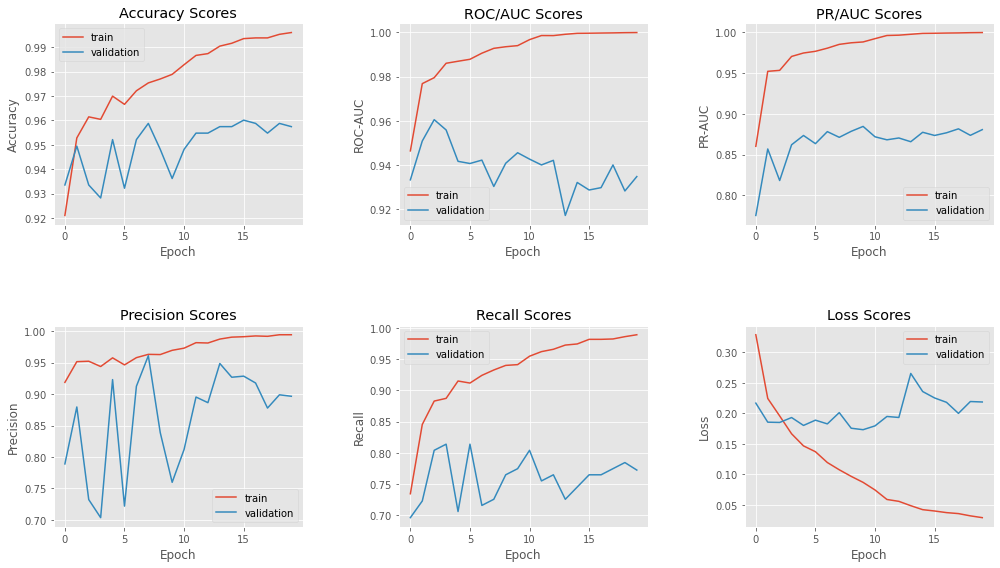

In [16]:
# create visualizations of training metrics
plt.style.use("ggplot")
sixplot2(history, "auc", "val_auc", "auc_1", "val_auc_1", "precision", "val_precision", "recall", "val_recall")

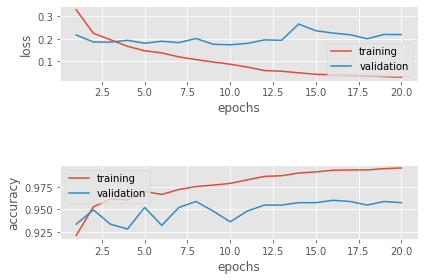

In [17]:
# visualization for loss and accuracy
train_val_metrics2(20, history)

## Loading Best Model

In [18]:
# load model with lowest validation loss
model = load_model('../logs/log_mobilenet/model.10-0.17.hdf5')

## Predicting on Holdout Set

753/753 [==============================] - 416s 553ms/step


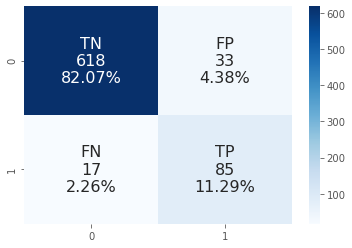

In [21]:
# display confusion matrix visualization
test_generator.reset()
pred = model.predict_generator(test_generator, steps = STEP_SIZE_TEST, verbose = 1)
y_true = test_generator.classes
y_pred = pred > 0.5
make_confusion_matrix(y_true, y_pred)

In [15]:
# get testing accuracy and loss
test_generator.reset()
score = model.evaluate_generator(test_generator, verbose = 1)

print("Loss: " + str(score[0]))
print("Accuracy: " + str(score[1]))
print("Precision: " + str(score[2]))
print("Recall: " + str(score[3]))
print("ROC-AUC: " + str(score[4]))
print("PR-AUC: " + str(score[5]))

753/753 [==============================] - 161s 208ms/step - loss: 0.2221 - accuracy: 0.9562 - precision: 0.9612 - recall: 0.9892 - auc: 0.9247 - auc_1: 0.9779
Loss: 0.22214962542057037
Accuracy: 0.9561753273010254
Precision: 0.9611940383911133
Recall: 0.9892473220825195
ROC-AUC: 0.9247462749481201
PR-AUC: 0.9779129028320312


## Save and Convert Best Model to TensorLite Flow

In [22]:
saved_model_dir = '../models/tensorlite' 
tf.saved_model.save(model, saved_model_dir) 

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) 
tflite_model = converter.convert()

with open('../models/model.tflite', 'wb') as f: 
  f.write(tflite_model)

INFO:tensorflow:Assets written to: ../models/tensorlite/assets
